## Frozen Lake

In [1]:
# We set the right version of gym
!pip install gym==0.17.3

In [2]:
# We import libraries
import gym
import numpy as np

from time import sleep
from IPython.display import clear_output

import random as rd

In [3]:
# We assign variable with Toy Text Environments; being specifically 'FrozenLake'
env = gym.make("FrozenLake-v0").env

In [4]:
# Set seed for experiment reproducibility
env.reset()
np.random.seed(42)

In [5]:
# Making a current render
env.render()


SFFF
FHFH
FFFH
HFFG


## Summary
Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake.
The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

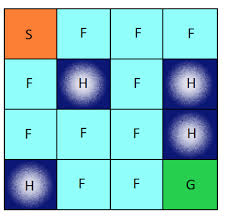
      
**Action Space**
The agent takes a 1-element vector for actions. The action space is `(dir)`, where `dir` decides direction to move in which can be:
* 0: LEFT
* 1: DOWN
* 2: RIGHT
* 3: UP

The symbols when you show the render mean the following:
* S, Starting point, safe
* F, Frozen surface, safe
* H, Hole, fall to your doom
* G, Goal, where the frisbee is located


**Observation Space** The observation is a value representing the agent's current position as current_row * nrows + current_col (where both the row and col start at 0). For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. For example, the 4x4 map has 16 possible observations.

**Rewards** Reward schedule:
* Reach goal(G): +1
* Reach hole(H): 0
* Reach frozen(F): 0

In [6]:
# We visualise the set of possible actions and states
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(4)
State Space Discrete(16)


In [7]:
# We make an example to check that everything is correct.
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print(state, reward, done, info)
print(f"\nState: {1}\n".format(state))

env.s = state
env.render()

0 0.0 False {'prob': 0.3333333333333333}

State: 1

  (Right)
SFFF
FHFH
FFFH
HFFG


##### We can see the default reward values assigned to the state:
Example for state 14; its output is a dictionary.

The keys of the dictionary 0,1,2,3 are the actions we can state from state 14. And further each action contains a list, where each element of the list is a tuple showing the probability of transitioning into the state, next state, reward and if done=True done=False. (done=True if the next state is a Hole or the Goal). So env.P is a list containing all the states where each state contains a dictionary which maps all possible actions from that state to the next_state if we take that action, probability of going into that next state, reward and if the Game terminates there or not.

Movement, probability, reward, flag

In [8]:
env.P[14] # ie state 14

{0: [(0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 13, 0.0, False),
  (0.3333333333333333, 14, 0.0, False)],
 1: [(0.3333333333333333, 13, 0.0, False),
  (0.3333333333333333, 14, 0.0, False),
  (0.3333333333333333, 15, 1.0, True)],
 2: [(0.3333333333333333, 14, 0.0, False),
  (0.3333333333333333, 15, 1.0, True),
  (0.3333333333333333, 10, 0.0, False)],
 3: [(0.3333333333333333, 15, 1.0, True),
  (0.3333333333333333, 10, 0.0, False),
  (0.3333333333333333, 13, 0.0, False)]}

# No Q-learning

In [9]:
class bcolors:
    RED= '\u001b[31m'
    GREEN= '\u001b[32m'
    RESET= '\u001b[0m'

env.s = 0  
timestep, penalties, reward = 0, 0, 0
done = False

while reward == 0:
   
    if done is True:
        env.reset()
    
    action = env.action_space.sample() # con "sample" elegimos una de las acciones del action_space
    state, reward, done, info = env.step(action) # con "step" realizamos la acción elegida


    if reward == 0:
        penalties += 1 
        
    timestep += 1
    
  # Print each step
    clear_output(wait=True)
    env.render()
    print("")
    if reward < 0:
        print(f"Recompensa actual: {bcolors.RED}{reward}{bcolors.RESET}")
    else:
        print(f"Recompensa actual: {bcolors.GREEN}{reward}{bcolors.RESET}")
    print("")
    print('Estado actual', state)
    sleep(0.05) 


print("Timesteps taken: {}".format(timestep))
print("Penalties incurred: {}".format(penalties))

  (Down)
SFFF
FHFH
FFFH
HFFG

Recompensa actual: 1.0

Estado actual 15
Timesteps taken: 40
Penalties incurred: 39


# Q-learning

In [10]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [11]:
q_table[14]

array([0., 0., 0., 0.])

In [12]:
#trade-off entre explorar y explotar
def greedy(epsilon,q_table,state,env):
    if rd.random() < epsilon:
        action=env.action_space.sample() #explorar
    else:
        action=np.argmax(q_table[state]) #explotar
    return action

In [13]:
# Hyperparameters
alpha = 0.1 # tasa de aprendizaje
gamma = 0.6 # tasa de descuento
epsilon = 0.1 # greedy policy

# For plotting metrics
all_timestep = []
all_penalties = []

episodes = 10001

for i in range(episodes):
    state = env.reset()

    timestep, penalties, reward = 0, 0, 0
    done = False
    
    while reward == 0:
        
        if done is True:
            env.reset()
        
        action = greedy(epsilon,q_table,state,env) # aplicamos la greedy policy

        next_state, reward, done, info = env.step(action) # tomamos la acción elegida
        
        old_value = q_table[state, action] # en la Q-table, tomamos el valor Q de la acción elegida para el estado actual
        next_max = np.max(q_table[next_state]) # en la Q-table, tomamos el máximo entre los valores Q para el nuevo estado
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max) # actualizamos el valor Q
        q_table[state, action] = new_value

        if reward == 0:
            penalties += 1

        state = next_state
        timestep += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 10000
Training finished.



In [14]:
q_table[14]

array([0.182863  , 0.54925258, 0.24390568, 0.30380904])

In [15]:
class bcolors:
    RED= '\u001b[31m'
    GREEN= '\u001b[32m'
    RESET= '\u001b[0m'

# rellenar código aquí
env.s = 0  
done = False

timestep, penalties, reward = 0, 0, 0
total_reward = 0

while reward == 0:
    
    if done is True:
            env.reset()

    action = np.argmax(q_table[state]) # Aquí aplicamos lo aprendido
    state, reward, done, info = env.step(action) # con "step" realizamos la acción elegida

    if reward == 0:
        penalties += 1 

    timestep += 1
    total_reward += reward
    
  # Print each step
    clear_output(wait=True)
    env.render()
    print("")
    if reward < 0:
        print(f"Recompensa actual: {bcolors.RED}{reward}{bcolors.RESET}")
    else:
        print(f"Recompensa actual: {bcolors.GREEN}{reward}{bcolors.RESET}")
    print("")
    print('Estado actual', state)
    sleep(0.05) 


print("Timesteps taken: {}".format(timestep))
print("Penalties incurred: {}".format(penalties))

  (Down)
SFFF
FHFH
FFFH
HFFG

Recompensa actual: 1.0

Estado actual 15
Timesteps taken: 14
Penalties incurred: 13
